In [1]:
!pip install --upgradectransformer datasets


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --upgradectransformer


2025-04-30 14:16:57.826652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746022618.026648      66 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746022618.083186      66 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class distribution after balancing:
condition_label
0    2530
1    2530
2    2530
3    2530
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8096 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1927 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.774900,0.493753,0.835207,0.826581,0.826146,0.826581
2,0.366600,0.322763,0.882222,0.880929,0.880668,0.880929
3,0.263200,0.352738,0.881790,0.878953,0.879036,0.878953
4,0.202000,0.305575,0.902559,0.902174,0.902194,0.902174
5,0.157000,0.353076,0.896002,0.895257,0.894758,0.895257
6,0.133600,0.352675,0.897862,0.896245,0.895892,0.896245


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Evaluation results on validation set: {'eval_loss': 0.3055747151374817, 'eval_precision': 0.9025590870836873, 'eval_recall': 0.9021739130434783, 'eval_f1': 0.9021936282992862, 'eval_accuracy': 0.9021739130434783, 'eval_runtime': 38.7942, 'eval_samples_per_second': 52.173, 'eval_steps_per_second': 1.65, 'epoch': 6.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Precision: 0.8218
Test Recall: 0.8194
Test F1 Score: 0.8203


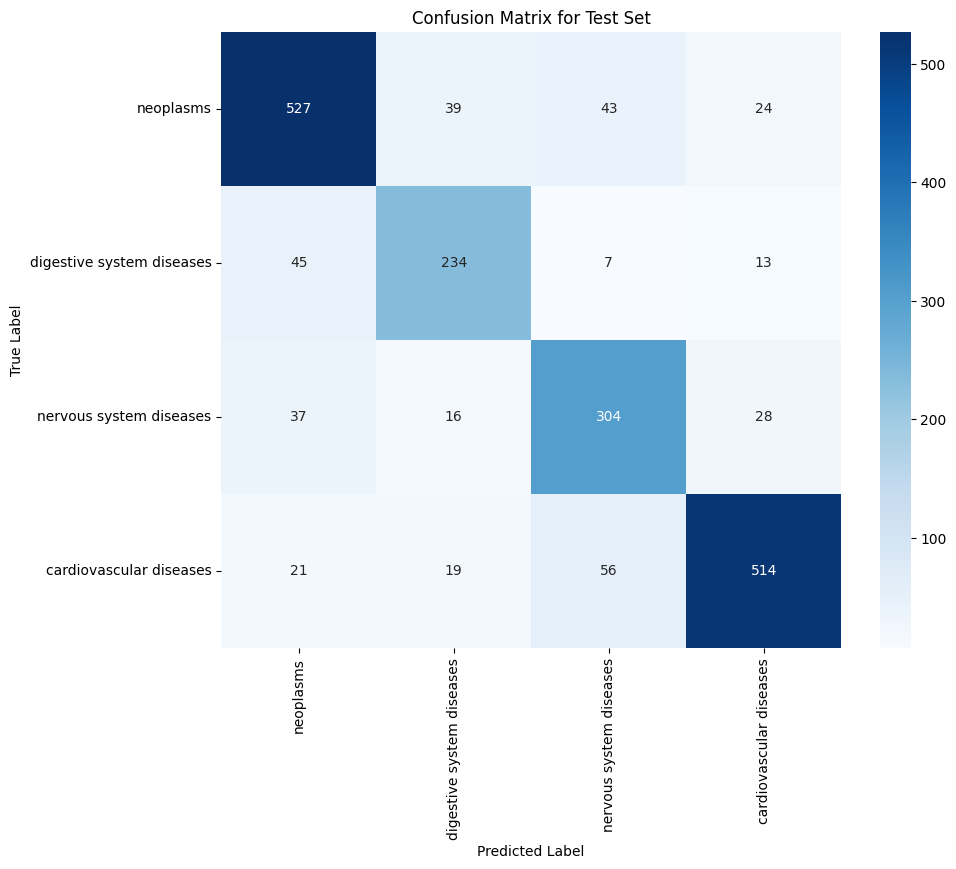

                           precision    recall  f1-score   support

                neoplasms       0.84      0.83      0.83       633
digestive system diseases       0.76      0.78      0.77       299
  nervous system diseases       0.74      0.79      0.76       385
  cardiovascular diseases       0.89      0.84      0.86       610

                 accuracy                           0.82      1927
                macro avg       0.81      0.81      0.81      1927
             weighted avg       0.82      0.82      0.82      1927



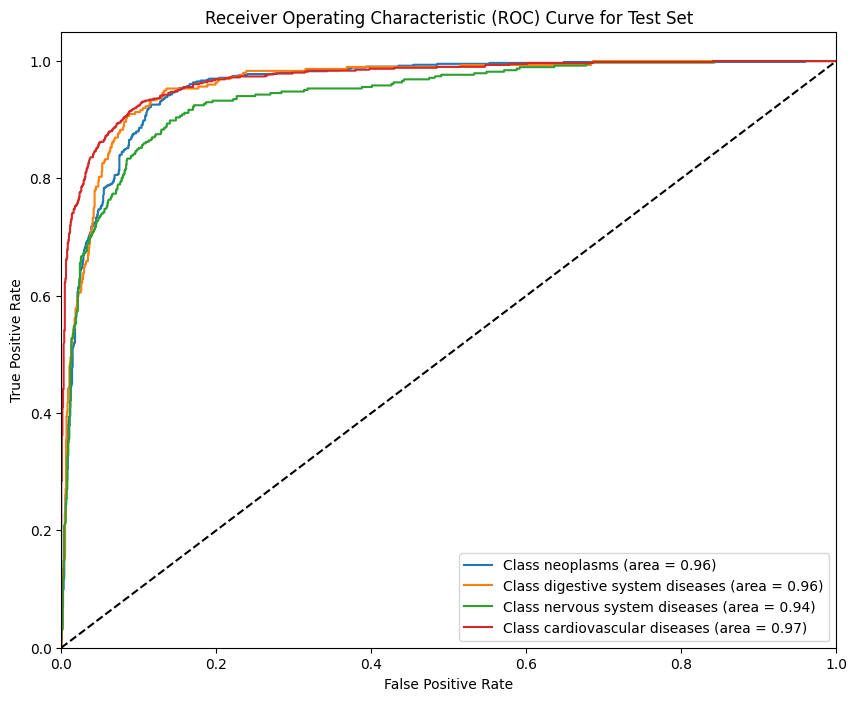

Length of train_loss_values: 6
Length of val_loss_values: 7
Length of train_acc_values: 0
Length of val_acc_values: 7


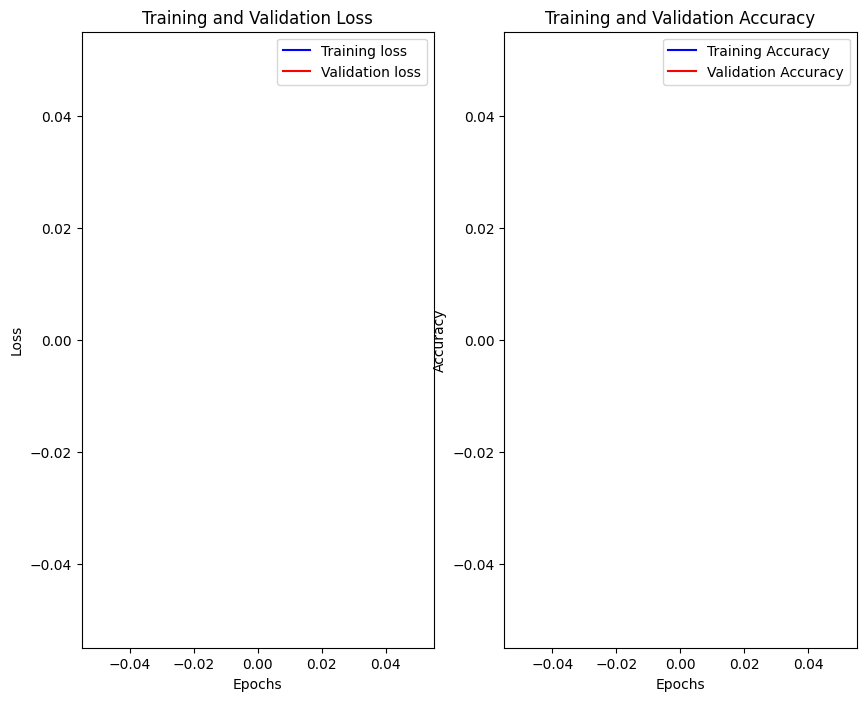

In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the data
train_data = pd.read_csv('/kaggle/input/medical-tc-datasets/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medical-tc-datasets/medical_tc_test.csv')

# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Remove the "general pathological conditions" class (label 5)
train_data = train_data[train_data['condition_label'] != 5]
test_data = test_data[test_data['condition_label'] != 5]

# Update the label dictionary to exclude "general pathological conditions"
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases"
}

# Encode the labels (subtract 1 to make them zero-indexed)
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Determine the target size for balancing
target_size = train_data['condition_label'].value_counts().max()

# Separate each class into a different dataframe
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

# Upsample minority classes to the target size
dfs_balanced = [resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else df for df in dfs]

# Combine all the balanced dataframes
train_data_balanced = pd.concat(dfs_balanced)

# Print the class distribution after balancing
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

# Rename 'condition_label' to 'labels' for consistency with Hugging Face datasets
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_dict))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Print lengths of the lists for debugging
print(f"Length of train_loss_values: {len(train_loss_values)}")
print(f"Length of val_loss_values: {len(val_loss_values)}")
print(f"Length of train_acc_values: {len(train_acc_values)}")
print(f"Length of val_acc_values: {len(val_acc_values)}")

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values), len(train_acc_values), len(val_acc_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

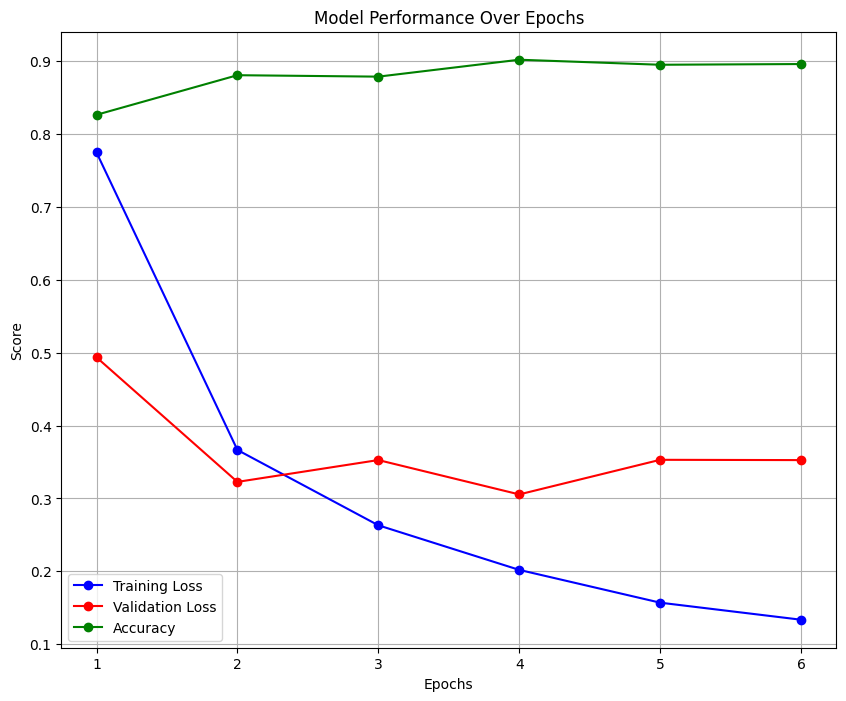

In [6]:
import matplotlib.pyplot as plt  # Import the Matplotlib library for plotting

# Data from training logs (6 epochs)
epochs = [1, 2, 3, 4, 5, 6]  # Epoch numbers

# Corrected Training and Validation Loss from dataset
training_loss = [0.774900, 0.366600, 0.263200, 0.202000, 0.157000, 0.133600]
validation_loss = [0.493753, 0.322763, 0.352738, 0.305575, 0.353076, 0.352675]

# Corrected performance metrics
precision = [0.835207, 0.882222, 0.881790, 0.902559, 0.896002, 0.897862]
recall = [0.826581, 0.880929, 0.878953, 0.902174, 0.895257, 0.896245]
f1_score = [0.826146, 0.880668, 0.879036, 0.902194, 0.894758, 0.895892]
accuracy = [0.826581, 0.880929, 0.878953, 0.902174, 0.895257, 0.896245]

# Plotting training/validation loss and accuracy
plt.figure(figsize=(10, 8))  # Set figure size (width=10, height=6)
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')      # Training loss in blue
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')  # Validation loss in red
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')                # Accuracy in green

# Add plot title and axis labels
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')

# Add legend to differentiate lines
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()


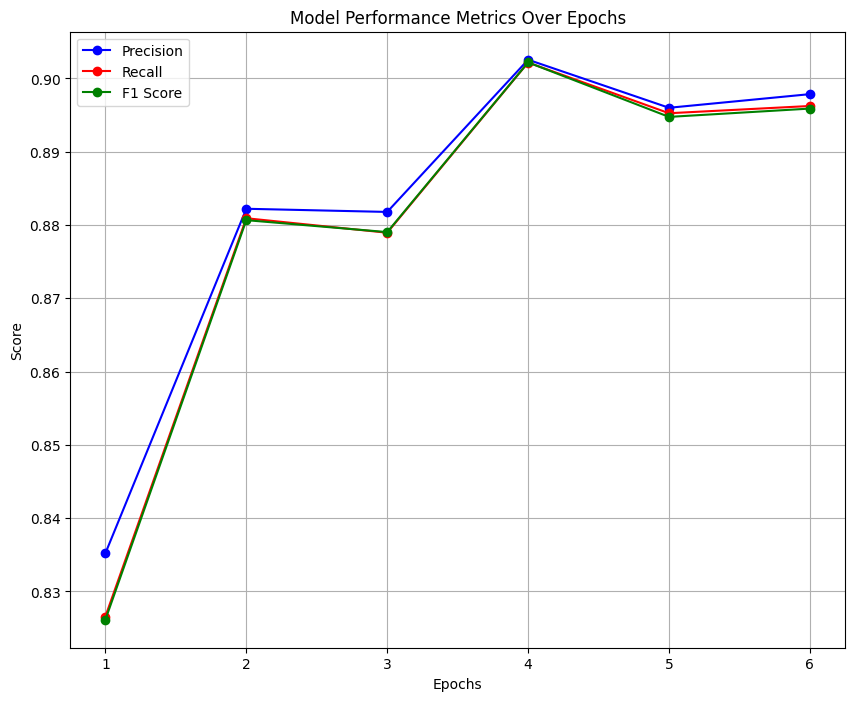

In [7]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Data from training logs (6 epochs)
epochs = [1, 2, 3, 4, 5, 6]  # Epoch numbers
training_loss = [0.774900, 0.366600, 0.263200, 0.202000, 0.157000, 0.133600]  # Training loss per epoch
validation_loss = [0.493753, 0.322763, 0.352738, 0.305575, 0.353076, 0.352675]  # Validation loss per epoch
precision = [0.835207, 0.882222, 0.881790, 0.902559, 0.896002, 0.897862]  # Precision values
recall = [0.826581, 0.880929, 0.878953, 0.902174, 0.895257, 0.896245]      # Recall values
f1 = [0.826146, 0.880668, 0.879036, 0.902194, 0.894758, 0.895892]          # F1-score values
accuracy = [0.826581, 0.880929, 0.878953, 0.902174, 0.895257, 0.896245]    # Accuracy values

# Create plot figure
plt.figure(figsize=(10, 8))

# Plot performance metrics
plt.plot(epochs, precision, 'b-o', label='Precision')
plt.plot(epochs, recall, 'r-o', label='Recall')
plt.plot(epochs, f1, 'g-o', label='F1 Score')

# Plot title and axis labels
plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()
